In [1]:
import boto3
import cufflinks as cf
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import warnings

from io import StringIO
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
cf.go_offline()
init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

In [3]:
def get_secret():
    secret_name = "s3_data_analysis"
    region_name = "us-east-1"

    # Create a Secrets Manager client with default credentials
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        # Retrieve the secret value from Secrets Manager
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    # Extract the secret string (which is a JSON object)
    secret = get_secret_value_response['SecretString']
    
    # Parse the secret string as JSON
    secrets = json.loads(secret)
    
    # Retrieve AWS credentials from the secrets
    aws_access_key_id = secrets['aws_access_key_id']
    aws_secret_access_key = secrets['aws_secret_access_key']
    
    # Now use the retrieved credentials to create the S3 client
    s3_client = boto3.client(
        's3',
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key
    )

    return s3_client

s3_client = get_secret()

In [4]:
def read_csv_from_s3(bucket_name, key, s3_client=None):
    
    if s3_client is None:
        s3_client = boto3.client('s3')
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=key)
        csv_content = response['Body'].read().decode('utf-8')
        data = StringIO(csv_content)
        df = pd.read_csv(data)
        return df
    except Exception as e:
         print(f"Error reading CSV from S3: {e}")
         return None

bucket_name = 'nk.data.analysis'
key = 'Bitcoin_Analysis/btcusd_1-min_data.csv'

df = read_csv_from_s3(bucket_name, key, s3_client)

In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

In [6]:
df = df.sort_index(ascending=False).reset_index()

In [7]:
df.drop('index', axis=1, inplace=True)

In [9]:
df = df[['Timestamp', 'Open', 'High', 'Low', 'Close']]

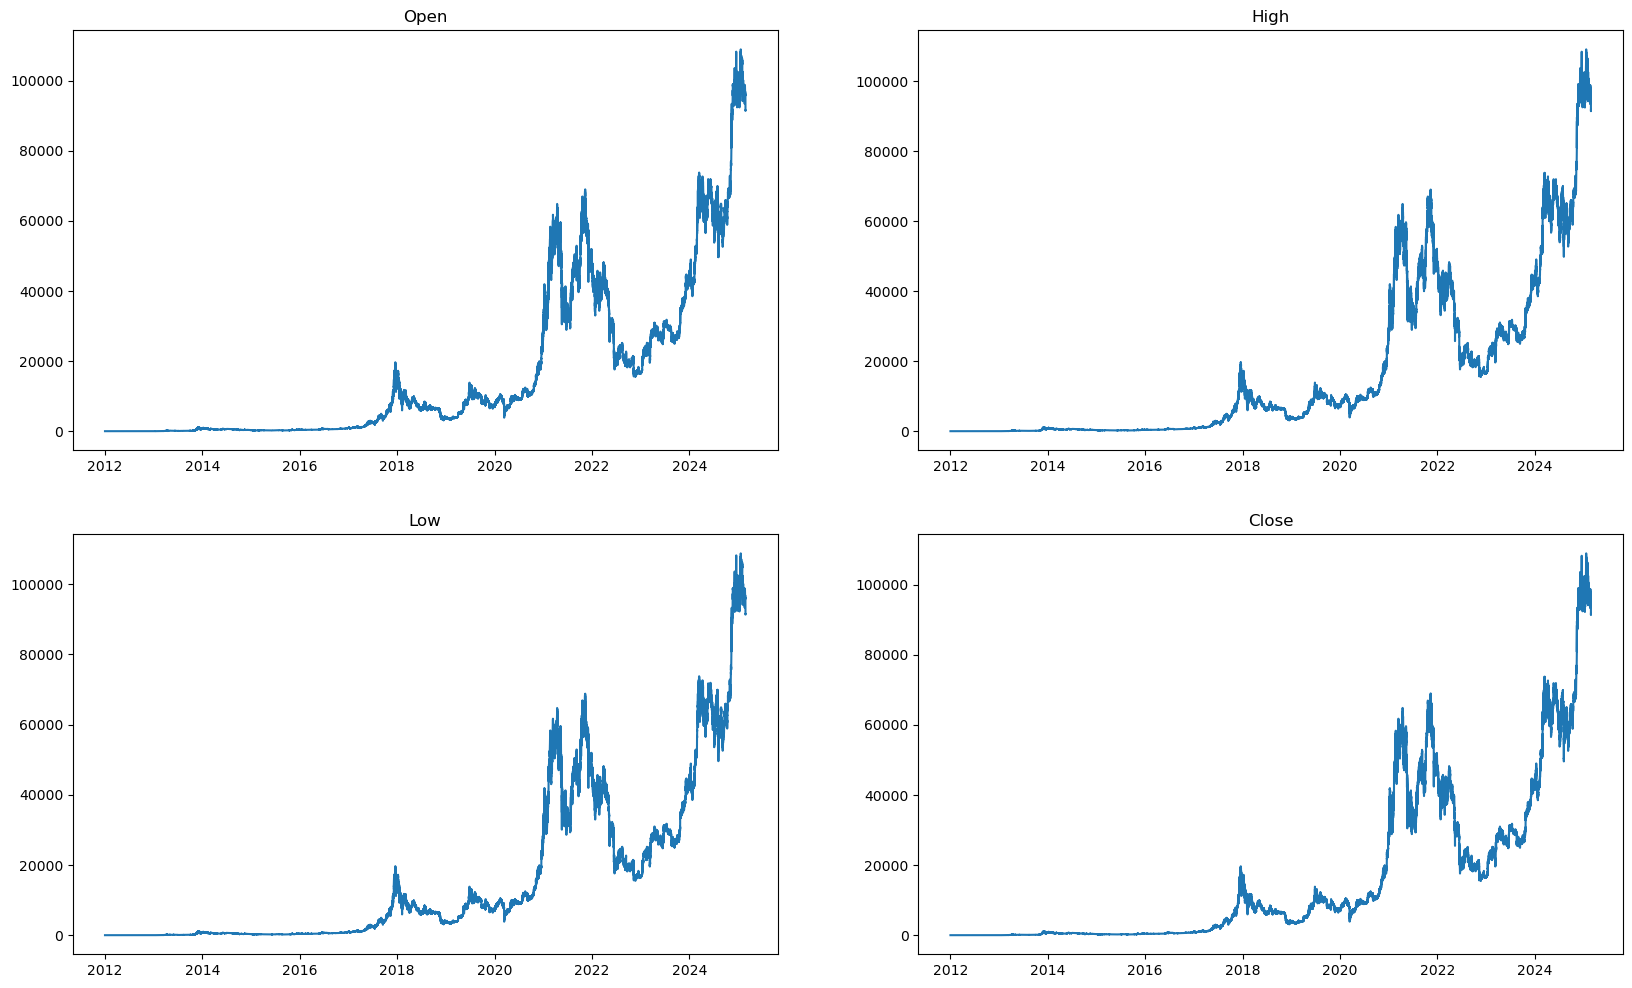

In [12]:
plt.figure(figsize = (20,12))
           
for index, col in enumerate(['Open', 'High', 'Low', 'Close'], 1):
    plt.subplot(2,2,index)
    plt.plot(df['Timestamp'], df[col])
    plt.title(col)
    

In [13]:
bitcoin_sample = df[0:50]

In [14]:
trace = go.Candlestick(x=bitcoin_sample['Timestamp'],
                       high = bitcoin_sample['High'],
                       low = bitcoin_sample['Low'],
                       open = bitcoin_sample['Open'],
                       close = bitcoin_sample['Close'])

In [15]:
candle_data = [trace]

layout = {
    'title':'Bitcoin Historical Prices',
    'xaxis':{'title':'Date'}
}

In [16]:
fig = go.Figure(data = candle_data, layout=layout)

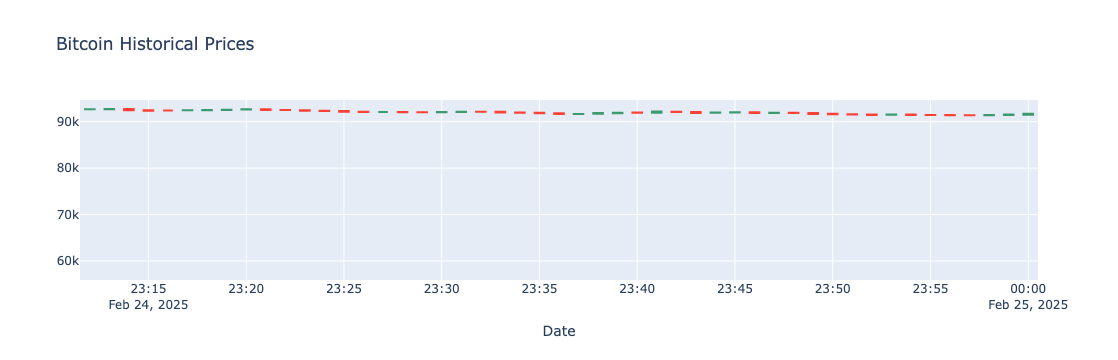

In [17]:
fig.update_layout(xaxis_rangeslider_visible = False)
fig.show()

In [18]:
df.set_index('Timestamp', inplace=True)

<Axes: xlabel='Timestamp'>

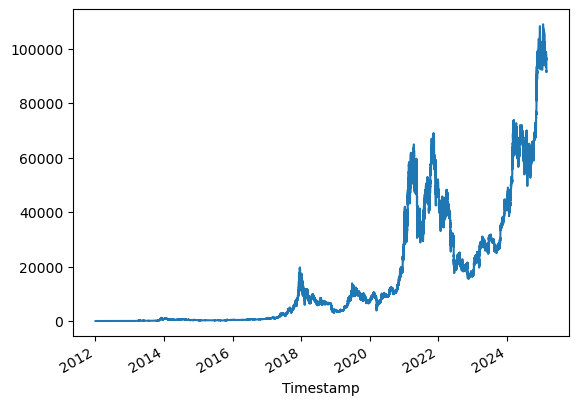

In [19]:
df['Close'].plot()

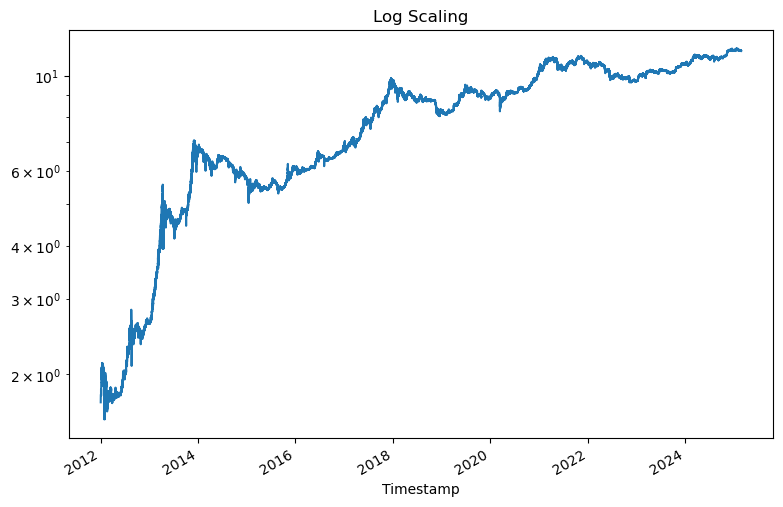

In [20]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,2)
np.log1p(df['Close']).plot()
plt.title('Log Scaling')
plt.yscale('log')

In [21]:
df['close_price_pct_change'] = df['Close'].pct_change()*100

<Axes: xlabel='Timestamp'>

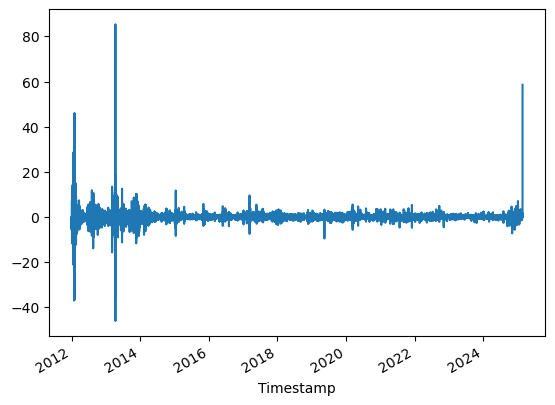

In [22]:
df['close_price_pct_change'].plot()

In [ ]:
df['close_price_pct_change'].iplot()